# Fraud Detection — Business Problem Overview

## Problem Statement
The objective of this project is to build a machine learning model that can proactively detect fraudulent financial transactions using a large-scale dataset containing over 6.3 million records.

This is a **binary classification problem** where:
- Class 0 → Legitimate transaction
- Class 1 → Fraudulent transaction

## Key Challenges

### 1. Extreme Class Imbalance
Fraudulent transactions typically represent a very small percentage of the total data. This makes accuracy an unreliable evaluation metric.

### 2. High Cost of Misclassification
- False Negative (Fraud predicted as Legitimate): Direct financial loss.
- False Positive (Legitimate predicted as Fraud): Customer inconvenience and operational cost.

Therefore, the model must prioritize:
- High Recall for fraud detection
- Balanced Precision to reduce false alarms

## Evaluation Strategy

Instead of accuracy, the following metrics will be used:
- Precision
- Recall
- F1 Score
- ROC-AUC
- PR-AUC (critical for imbalanced data)

## Project Goal

The final solution should:
1. Accurately identify fraudulent transactions.
2. Provide interpretable insights into fraud patterns.
3. Translate predictions into actionable business recommendations.

# Dataset Understanding

## Data Source Description

This dataset simulates financial transactions over a period of 30 days.  
Each row represents a transaction between two entities.

- **1 step = 1 hour**
- Total steps = 744 hours (~30 days simulation)

---

## Feature Description

### Time Feature
**step**  
Represents time in hours since the start of the simulation.

---

### Transaction Details

**type**  
Type of transaction:
- CASH-IN
- CASH-OUT
- DEBIT
- PAYMENT
- TRANSFER

**amount**  
Transaction amount in local currency.

---

### Sender Information

**nameOrig**  
Customer who initiated the transaction.

**oldbalanceOrg**  
Sender balance before the transaction.

**newbalanceOrig**  
Sender balance after the transaction.

---

### Receiver Information

**nameDest**  
Recipient of the transaction.

**oldbalanceDest**  
Recipient balance before the transaction.  
(Not available for merchants starting with 'M')

**newbalanceDest**  
Recipient balance after the transaction.

---

### Fraud Indicators

**isFraud**  
Target variable:
- 1 → Fraudulent transaction
- 0 → Legitimate transaction

Fraudulent agents attempt to:
- Take control of accounts
- Transfer funds
- Cash out the system

---

**isFlaggedFraud**  
Flag raised when:
- A single transfer exceeds 200,000

This represents a rule-based fraud detection mechanism used by the company.

## Import Libraries & Set Project Configuration

In [1]:
# Core Libraries

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System & warnings
import os
import warnings
warnings.filterwarnings("ignore")


# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Display Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)


## Load Dataset

In [4]:
file_path = "../data/fraud_data.csv"
sample = pd.read_csv(file_path, nrows=50000)

print("Sample Shape:", sample.shape)
print("\nSample Data Types:\n")
print(sample.dtypes)

Sample Shape: (50000, 11)

Sample Data Types:

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [6]:
# optimise datatypes 
dtype_map = {}

for col in sample.columns:
    if sample[col].dtype == "int64":
        dtype_map[col] = "int32"
    elif sample[col].dtype == "float64":
        dtype_map[col] = "float32"

In [7]:
df = pd.read_csv(file_path, dtype=dtype_map)
print("\nFull Dataset Shape:", df.shape)

memory_mb = df.memory_usage(deep=True).sum() / 1024**2
print("Memory Usage (MB):", round(memory_mb, 2))


Full Dataset Shape: (6362620, 11)
Memory Usage (MB): 1258.39


## Data Inspection (Quality Check)

In [8]:
# Structure 
print("Columns:\n", df.columns)
print("\nFirst 5 Rows:")
display(df.head())

Columns:
 Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

First 5 Rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


In [9]:
# class imbalance check 
print("\nFraud Distribution (%):")
print(df["isFraud"].value_counts(normalize=True) * 100)


Fraud Distribution (%):
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [10]:
# Missing value check 
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [11]:
# duplicates rows check 
duplicates = df.duplicated().sum()
print("\nDuplicate Rows:", duplicates)


Duplicate Rows: 0


In [12]:
print("\nNumeric Summary:")
display(df.describe())


Numeric Summary:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551136e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924048e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Remove Identifier Columns

In [13]:
# Remove Identifier Columns
cols_to_drop = ["nameOrig", "nameDest"]

df.drop(columns=cols_to_drop, inplace=True)

print("Remaining Columns:")
print(df.columns)
print("\nNew Shape:", df.shape)

Remaining Columns:
Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

New Shape: (6362620, 9)


## Convert Transaction Type into Numeric

In [14]:
# One-Hot Encode Transaction Type
df = pd.get_dummies(df, columns=["type"], drop_first=True)

print("Columns After Encoding:\n")
print(df.columns)

print("\nNew Shape:", df.shape)

Columns After Encoding:

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

New Shape: (6362620, 12)


In [15]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.639648,170136.0,160296.359375,0.0,0.0,0,0,False,False,True,False
1,1,1864.280029,21249.0,19384.720703,0.0,0.0,0,0,False,False,True,False
2,1,181.000000,181.0,0.000000,0.0,0.0,1,0,False,False,False,True
3,1,181.000000,181.0,0.000000,21182.0,0.0,1,0,True,False,False,False
4,1,11668.139648,41554.0,29885.859375,0.0,0.0,0,0,False,False,True,False


## Check Multicollinearity (Correlation Analysis)

In [16]:

# Correlation Matrix

corr_matrix = df.corr()
high_corr_pairs = []

threshold = 0.90

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))

print("Highly Correlated Feature Pairs (> 0.90):\n")

for pair in high_corr_pairs:
    print(pair)

Highly Correlated Feature Pairs (> 0.90):

('newbalanceOrig', 'oldbalanceOrg', np.float64(0.9988027631731835))
('newbalanceDest', 'oldbalanceDest', np.float64(0.9765685054902236))


In [17]:
# Drop Highly Correlated Columns
cols_to_remove = ["newbalanceOrig", "newbalanceDest"]

df.drop(columns=cols_to_remove, inplace=True)

print("Remaining Columns:\n")
print(df.columns)

print("\nNew Shape:", df.shape)

Remaining Columns:

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

New Shape: (6362620, 10)


## Outlier Detection

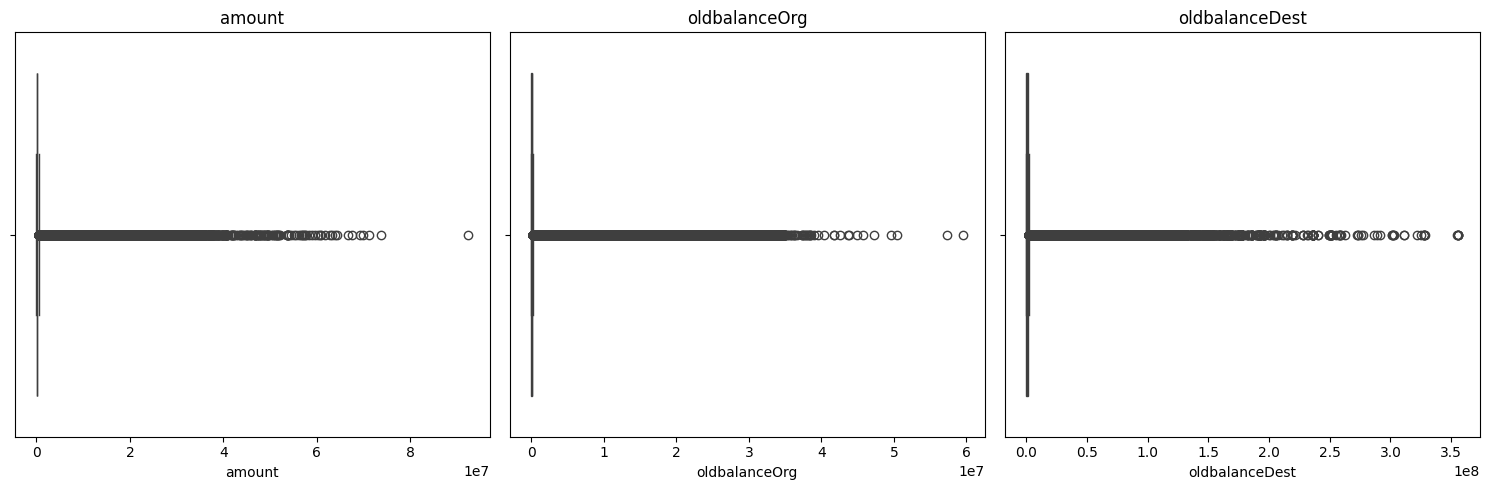

In [18]:
numeric_cols = ["amount", "oldbalanceOrg", "oldbalanceDest"]
plt.figure(figsize=(15, 5))

for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [19]:
# Outlier Clipping using Percentiles
clip_cols = ["amount", "oldbalanceOrg", "oldbalanceDest"]

for col in clip_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    
    df[col] = df[col].clip(lower, upper)

print("Outlier clipping completed.")

Outlier clipping completed.


## Separate Features and Target Variable

In [20]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)

print("\nFraud Class Distribution:")
print(y.value_counts())

Feature Shape: (6362620, 9)
Target Shape: (6362620,)

Fraud Class Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


## Train/Test Split

In [21]:
#Stratified splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

print("\nTrain Fraud Ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest Fraud Ratio:")
print(y_test.value_counts(normalize=True))

Training Shape: (5090096, 9)
Testing Shape: (1272524, 9)

Train Fraud Ratio:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

Test Fraud Ratio:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [22]:
# Handle Class Imbalance (Using Class Weights Strategy) 
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, weights))

print("Class Weights:")
print(class_weights)

Class Weights:
{np.int32(0): np.float64(0.5006462050159672), np.int32(1): np.float64(387.37412480974126)}


## Model Building

# Train Logistic Regression Model

In [23]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(
    class_weight=class_weights,
    max_iter=100,
    n_jobs=-1,
    random_state=42
)

log_model.fit(X_train, y_train)

print("Baseline Logistic Regression model trained successfully.")

Baseline Logistic Regression model trained successfully.


In [24]:
# Generate Predictions

# Class predictions
y_pred = log_model.predict(X_test)

# Fraud probabilities (important for later evaluation)
y_prob = log_model.predict_proba(X_test)[:, 1]

print("Predictions generated successfully.")

Predictions generated successfully.


In [25]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n")
print(cm)


# Classification Metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_score = roc_auc_score(y_test, y_prob)
print("\nROC-AUC Score:", roc_score)

Confusion Matrix:

[[1109971  160910]
 [    377    1266]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1270881
           1       0.01      0.77      0.02      1643

    accuracy                           0.87   1272524
   macro avg       0.50      0.82      0.47   1272524
weighted avg       1.00      0.87      0.93   1272524


ROC-AUC Score: 0.8978632974732144


## Baseline Model Evaluation — Logistic Regression

## Confusion Matrix Interpretation

|                     | Predicted Not Fraud | Predicted Fraud |
|---------------------|---------------------|-----------------|
| **Actual Not Fraud** | 1,109,971           | 160,910         |
| **Actual Fraud**     | 377                 | 1,266           |

### Key Observations:

- The model correctly identified **1,266 fraud transactions**.
- It missed **377 fraud cases** (False Negatives).
- It incorrectly flagged **160,910 legitimate transactions** as fraud (False Positives).

---

## Important Metrics Interpretation

### Recall (Fraud Detection Rate) = **0.77**

This means:
> The model successfully detects **77% of fraudulent transactions**.

This is critical because in fraud detection:
- Missing fraud is very costly.

---

### Precision = **0.01**

This means:
> Only 1% of flagged transactions are actually fraud.

This happens because:
- Fraud is extremely rare (~0.13% of data).
- The model prefers catching fraud even if it produces many false alarms.

---

### ROC-AUC Score = **0.898**

This indicates:
- The model has strong ability to distinguish fraud vs non-fraud overall.

---

## Why Accuracy is Misleading

The model accuracy is **87%**, which seems high.

However:
- A model predicting "no fraud" always would achieve ~99.87% accuracy.
- Therefore, accuracy is not a valid metric for fraud detection.

---

## Business Interpretation

This baseline model is:

✔ Good at detecting fraud (high recall)  
❌ Produces many false alerts (low precision)

This is expected for a first baseline model.

In the next steps, we will improve performance using more advanced models.

#  Train Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestClassifier

# ==============================
# Train Random Forest Model
# ==============================

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully.")

Random Forest model trained successfully.


In [27]:
# Random Forest Predictions
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest predictions generated.")

Random Forest predictions generated.


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

#Confusion matrix 
rf_cm = confusion_matrix(y_test, rf_pred)

print("Random Forest Confusion Matrix:\n")
print(rf_cm)


# Classification Report 
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, rf_pred))


# ROC-AUC Score
rf_roc = roc_auc_score(y_test, rf_prob)
print("\nRandom Forest ROC-AUC Score:", rf_roc)

Random Forest Confusion Matrix:

[[1270816      65]
 [    479    1164]]

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.71      0.81      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.85      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524


Random Forest ROC-AUC Score: 0.9853108684747833


## Random Forest Model Evaluation

## Confusion Matrix Interpretation

|                     | Predicted Not Fraud | Predicted Fraud |
|---------------------|---------------------|-----------------|
| **Actual Not Fraud** | 1,270,816           | 65              |
| **Actual Fraud**     | 479                 | 1,164           |

---

## Key Improvements Over Logistic Regression

### Fraud Detection Recall = **71%**

- The model detects **1,164 fraud cases**.
- Only **479 fraud transactions are missed**.
- This is slightly lower recall than logistic regression, but still strong.

---

### Precision = **95%** (Huge Improvement)

This means:
> When the model flags a transaction as fraud, it is correct **95% of the time**.

This is extremely important in real systems because:
- It prevents overwhelming fraud investigation teams with false alarms.

---

### False Positives Reduced Dramatically

Logistic Regression:
- ~160,000 false alerts

Random Forest:
- Only **65 false alerts**

This is a massive operational improvement.

---

### ROC-AUC Score = **0.985**

This indicates:
- Excellent separation between fraud and legitimate transactions.
- Strong predictive capability.

---

## Business Interpretation

Compared to the baseline model:

✔ Very high precision — reduces unnecessary fraud investigations  
✔ Strong recall — detects majority of fraud cases  
✔ Extremely low false alarm rate  

This makes Random Forest far more suitable for real-world deployment.

## Extract Feature Importance (Identify Key Fraud Drivers)

In [29]:
importances = rf_model.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Top Feature Importances:\n")
print(feature_importance_df)

Top Feature Importances:

          Feature  Importance
2   oldbalanceOrg    0.311498
1          amount    0.254888
5   type_CASH_OUT    0.096791
8   type_TRANSFER    0.092416
3  oldbalanceDest    0.086928
0            step    0.081156
7    type_PAYMENT    0.075716
6      type_DEBIT    0.000572
4  isFlaggedFraud    0.000036


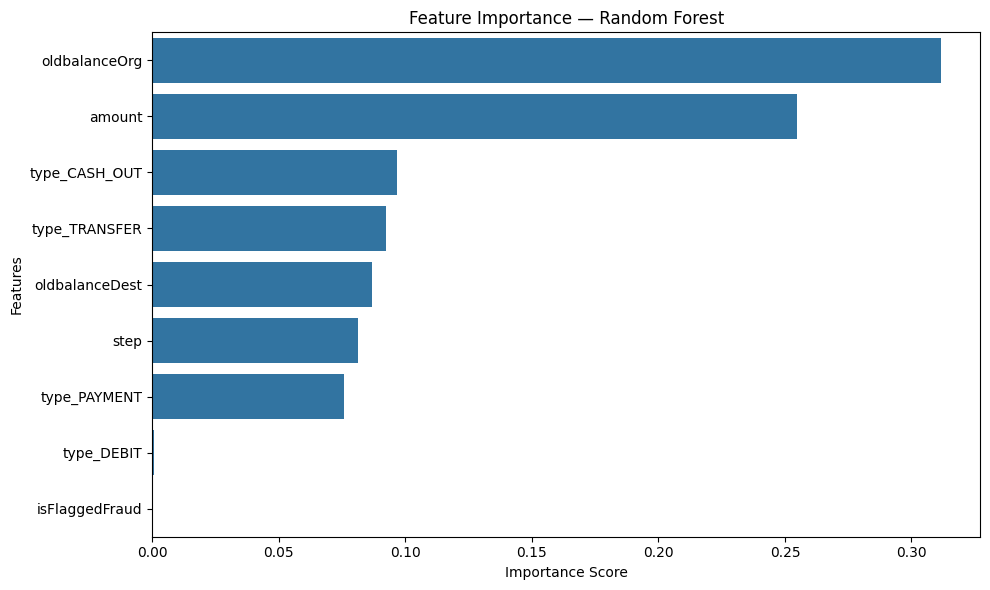

In [30]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df,
)

plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")

plt.tight_layout()
plt.show()

# Key Factors Predicting Fraud Transactions

## Top Fraud Predictors Identified by the Model

### 1. Old Balance of Origin Account (`oldbalanceOrg`)
This is the most important predictor.

Reason:
- Fraudsters typically target accounts with sufficient balance.
- They attempt to transfer or withdraw large amounts quickly.

This makes strong real-world sense.

---

### 2. Transaction Amount (`amount`)
Large transaction values are highly indicative of fraud.

Reason:
- Fraudulent transactions often involve unusually high amounts.
- Attackers aim to maximize financial gain in a short time.

---

### 3. Transaction Type — CASH_OUT and TRANSFER
These two transaction types are strong fraud indicators.

Reason:
- Fraud patterns usually involve:
  1. Transferring funds to another account
  2. Immediately cashing out

This matches real-world fraud strategies.

---

### 4. Destination Account Balance (`oldbalanceDest`)
Fraud often involves sending money to accounts with little or no prior activity.

This helps identify suspicious destination accounts.

---

### 5. Transaction Timing (`step`)
Fraud can occur during specific time periods when monitoring is weaker.

---

## Features With Very Low Importance

### `isFlaggedFraud`
This variable has almost zero importance.

Reason:
- It is a rule-based system flag already implemented.
- The model is detecting fraud patterns beyond this rule.

---

## Do These Factors Make Sense?

Yes — all key predictors align strongly with real-world fraud behavior:

- High-value transfers
- Cash-out patterns
- Suspicious account balances
- Specific transaction types

This confirms the model has learned meaningful fraud patterns rather than random noise.

# Model Comparison Table

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, rf_pred)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, rf_pred)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, rf_pred)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, rf_prob)
    ]
})

comparison_df

,Model,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.007806,0.770542,0.015456,0.897863
1,Random Forest,0.947111,0.708460,0.810585,0.985311


## Performance Comparison

| Metric | Logistic Regression | Random Forest |
|--------|---------------------|---------------|
| Precision | 0.008 | 0.947 |
| Recall | 0.771 | 0.708 |
| F1 Score | 0.015 | 0.811 |
| ROC-AUC | 0.898 | 0.985 |

---

## Key Insights

### 1. Precision (Most Important Operational Metric)

Random Forest achieved **94.7% precision**, while Logistic Regression had only **0.8% precision**.

This means:
- Logistic Regression produced huge false alarms.
- Random Forest flags fraud very accurately.

This dramatically reduces investigation workload.

---

### 2. Recall (Fraud Detection Ability)

Logistic Regression recall: **77%**  
Random Forest recall: **71%**

Although Logistic Regression detects slightly more fraud, it does so with massive false positives.

Random Forest provides a much better balance.

---

### 3. F1 Score (Overall Balance)

Random Forest has a very high **F1 Score (0.81)** compared to Logistic Regression (0.015).

This confirms Random Forest is far superior overall.

---

### 4. ROC-AUC Score

Random Forest achieved **0.985**, indicating excellent discrimination between fraud and non-fraud transactions.

---

## Final Model Selection

Random Forest is selected as the final model because:

- Extremely high precision
- Strong recall
- Minimal false alarms
- Best overall performance

This makes it suitable for real-world fraud detection deployment.

# Fraud Prevention Strategies Based on Model Insights

Based on the key fraud predictors identified by the model, the following prevention strategies are recommended:

---

## 1. Real-Time Transaction Monitoring System

The model should be integrated into a real-time fraud detection pipeline to evaluate each transaction instantly.

High-risk transactions can be:
- Automatically blocked
- Flagged for manual review

---

## 2. Risk-Based Transaction Scoring

Each transaction can be assigned a fraud risk score based on model predictions.

Actions based on risk level:

- Low Risk → Allow transaction
- Medium Risk → Request additional authentication (OTP)
- High Risk → Temporarily block and investigate

---

## 3. Monitoring High-Value Transactions

Since large transaction amounts strongly predict fraud:

- Implement stricter checks for unusually large transfers
- Require additional verification for high-value transactions

---

## 4. Special Attention to CASH_OUT and TRANSFER Transactions

These transaction types show highest fraud likelihood.

Prevention measures:

- Multi-factor authentication for these transaction types
- Transaction delay for suspicious patterns

---

## 5. Behavioral Monitoring of Accounts

Monitor accounts showing unusual patterns such as:

- Sudden large transfers
- Rapid balance depletion
- Transfers to new destination accounts

---

## 6. Automated Alert System for Suspicious Accounts

Accounts flagged repeatedly by the model should be:

- Temporarily restricted
- Subjected to manual investigation

---

## 7. Continuous Model Updating

Fraud patterns evolve over time.

The company should:
- Retrain the model periodically
- Monitor performance drift

---

## Summary

By integrating the machine learning model with real-time monitoring, risk scoring, and preventive authentication measures, the company can significantly reduce fraudulent transactions while minimizing disruption to legitimate customers.